# Latent Autoregressive Model

Suppose that $y$ is Negative Binomial distributed over the exponential of a latent time series modeled by an autoregressive process with $W$ lags, i.e., 

$$y(t) \sim \text{NegBin}( \mu = \exp(f(t)), \alpha )$$

where for each $t$, $f(t)$ is a linear combination of the past $W$ timesteps, i.e.,

$$f(t) = \text{inner_prod}(\beta, [f(t-1)...f(t-W)])$$

### Benefits

1. Using PyMC3's builtin AR process implementation allows us to handle missing data easily.
1. Modeling our counts as NegBin distributed over the exponential of a latent process will make the two models (GLM & GGP) more analogous and offer better comparisons for heldout scoring.
    - Note: I'm using exp() as my link function because the mean for the NegBin must be restricted to positives only. In the old model, I was using an if statement to catch predictions that were <= 0.

### Forecasting procedure - not sure about this

For each posterior sample in the trace:
1. Compute the next latent value $f$ using the current posterior sample.
1. Draw forecast from a NegBin dist with $\mu=\exp(f)$ and $\alpha$ set to the current $\alpha$.
1. Add the $\log$ of the forecast to the array of past latent values.
1. Repeat n_predictions times.

In [16]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt

In [17]:
train_df = pd.read_csv("../../code/Middlesex.csv")
counts = train_df['cases'].values.astype(float)
counts = pd.Series(counts)

In [19]:
W = 4

with pm.Model() as ar4:
    bias = pm.Normal('beta[0]', mu=0, sigma=1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=1)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=1)
        rho.append(beta)
    f = pm.AR('f', rho, constant=True, shape=len(counts))
    alpha = pm.TruncatedNormal('alpha', mu=2000, sigma=500, lower=0)
    y = pm.NegativeBinomial('y', mu=tt.exp(f), alpha=alpha, observed=counts)

In [20]:
with ar4:
    trace = pm.sample(tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, f, beta[4], beta[3], beta[2], beta[1], beta[0]]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:56<00:00, 105.52draws/s]


In [22]:
print(f'Score = {y.logp(trace[-1]) / len(counts)}')

Score = -4.435155537378749


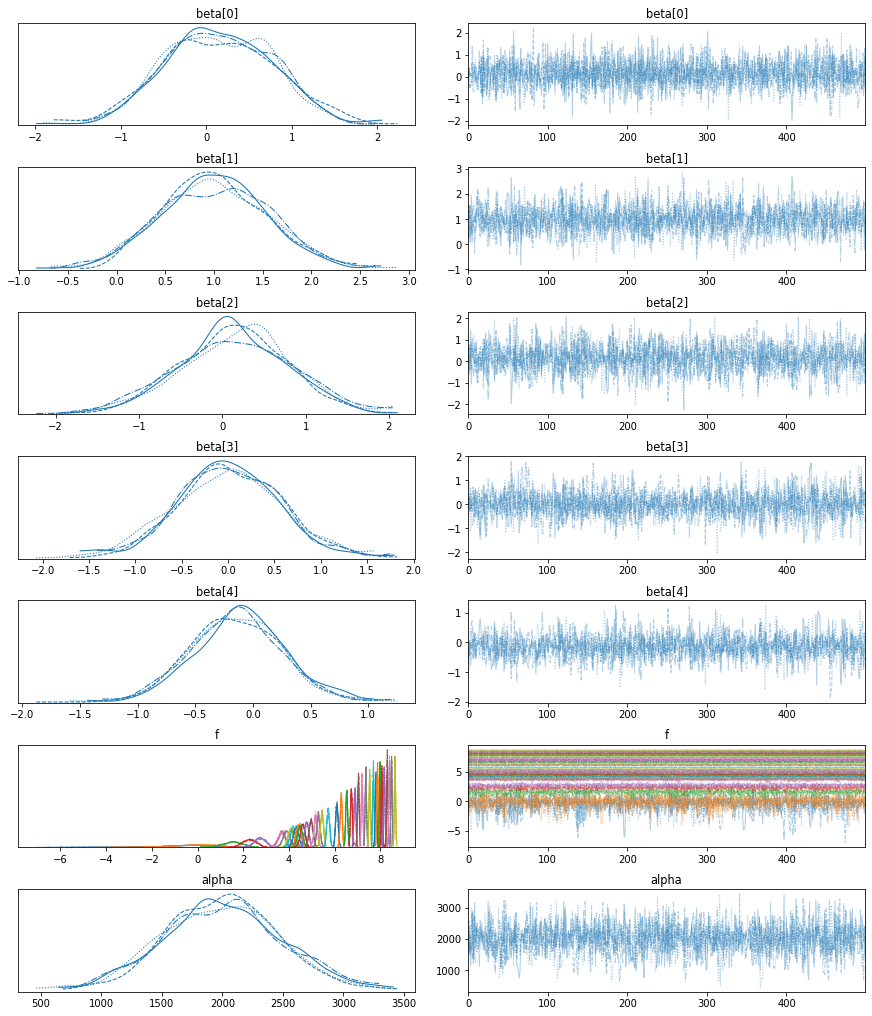

In [23]:
pm.traceplot(trace);

In [ ]:
# Forecasting code - not working perfectly

n_predictions = 7
n_samples = len(trace)

def get_f(point, history):
    f = 0.0
    f += point['beta'][0]
    for i in range(1, W+1):
        f += point['beta'][i] * history[-i]
    return f

past = np.zeros(W + n_predictions)
past[:W] = np.log(counts[-W:])
samples = np.zeros((n_samples,n_predictions))

for i in range(n_samples):
    if(i % 10 == 0):
        print(f'Collected {i} samples...')
    
    point = trace[i]
    beta = np.zeros(W+1)
    for i in range(W+1):
        beta[i] = point[f'beta[{i}]']
    point['beta'] = beta
            
    for j in range(n_predictions):
        f = get_f(point, past[j:j+W])
        y_t = pm.NegativeBinomial.dist(mu=tt.exp(f), alpha=point['alpha'])
        sample = y_t.random()
        samples[i][j] = sample
        past[j+W] = np.log(sample)

### Handling missing data

Now let's suppose that our dataset has some missing value.

In [66]:
counts[10] = np.nan

In [85]:
W = 4

with pm.Model() as ar4:
    bias = pm.Normal('beta[0]', mu=0, sigma=1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=1)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=1)
        rho.append(beta)
    f = pm.AR('f', rho, constant=True, shape=len(counts))
    alpha = pm.TruncatedNormal('alpha', mu=2000, sigma=500, lower=0)
    y = pm.NegativeBinomial('y', mu=tt.exp(f), alpha=alpha, observed=counts)

/Users/allylee/miniconda3/envs/spr_2020s_env/lib/python3.8/site-packages/pymc3/model.py:1430: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [86]:
with ar4:
    trace = pm.sample(tune=1000, init='adapt_diag')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha, f, beta[4], beta[3], beta[2], beta[1], beta[0]]
>Metropolis: [y_missing]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:43<00:00, 138.33draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [87]:
print(f'Score = {y.logp(trace[-1]) / len(counts)}')

Score = -4.520302402677216


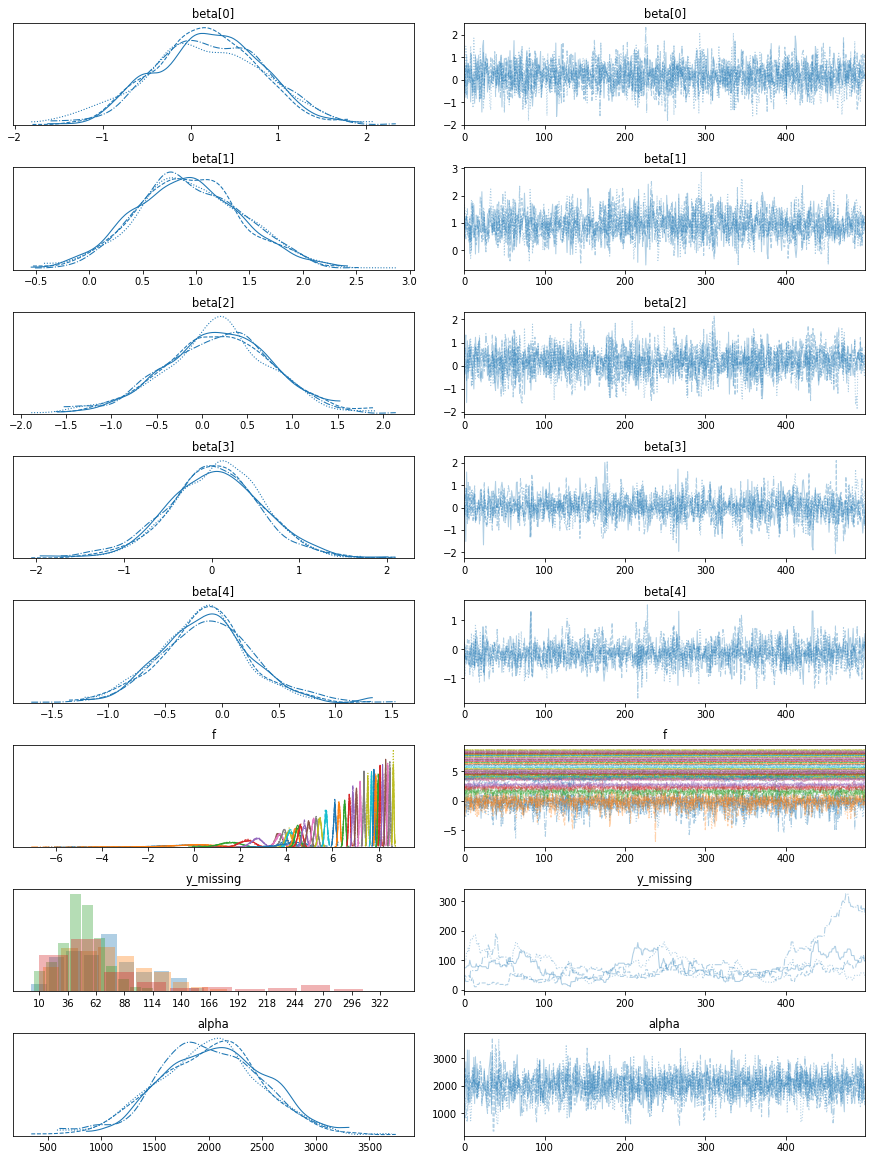

In [88]:
pm.traceplot(trace);

Actual missing value: 75


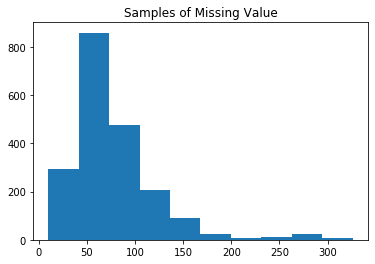

In [89]:
print('Actual missing value: 75')
plt.title('Samples of Missing Value')
plt.hist(trace['y_missing']);